In [ ]:
Assignment 2: Cats vs. Dogs Classification
Dataset: Kaggle Cats vs. Dogs (25,000 labeled images)
Task:
Build a binary classification model to distinguish cats from dogs.
Use data augmentation (flip, rotate, zoom) to prevent overfitting.
Evaluate the model's accuracy and precision.
Expected Outcomes:
Achieve at least 85-90% accuracy.
Display a confusion matrix and classification report.
Bonus Challenges:
Use data augmentation to reduce overfitting.
Experiment with Dropout layers and regularization.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

C:\Users\Saswata Maity\.conda\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|███████████████████████████████████████████████████████████████████████████████| 788M/788M [01:24<00:00, 9.78MB/s]

Extracting files...


Path to dataset files: C:\Users\Saswata Maity\.cache\kagglehub\datasets\shaunthesheep\microsoft-catsvsdogs-dataset\versions\1


In [47]:
data_path=r"C:\Users\Saswata Maity\.cache\kagglehub\datasets\shaunthesheep\microsoft-catsvsdogs-dataset\versions\1\PetImages"

In [49]:
import os
import shutil
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt

# Dataset
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [50]:
# Set Image Directory
image_dir = data_path
# Extract class names
class_names = sorted(os.listdir(image_dir))

# Number of Images
n_images = [len(os.listdir(os.path.join(image_dir, name))) for name in class_names]

print(f'Class Names: {class_names}')

print(f'No of images per class: {n_images}')

Class Names: ['Cat', 'Dog']
No of images per class: [12501, 12501]


In [51]:
# Set some constants
n_train_images = 10000
n_test_images = 1000

# Create Training & Testing Directories
train_dir, test_dir = './train_dir', './test_dir'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Copy Images from OG location to Target Location
for name in class_names:

    # Make Sure Sub Directory Exists for Training
    dest_train_dir = os.path.join(train_dir, name)
    os.makedirs(dest_train_dir, exist_ok=True)

    # Load Input Image Paths for Training
    train_image_paths = sorted(glob(os.path.join(image_dir, name, "*")))[:n_train_images]

    # Copy the images for Training
    for image_path in tqdm(train_image_paths):
        try:
            # Load the image to ensure it is valid
            Image.open(image_path)
            target_path = os.path.join(dest_train_dir, os.path.basename(image_path))
            shutil.copy(image_path, target_path)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

# Copy Images from OG location to Target Location for Testing
for name in class_names:
    
    # Make Sure Sub Directory Exists for Testing
    dest_test_dir = os.path.join(test_dir, name)
    os.makedirs(dest_test_dir, exist_ok=True)

    # Load Input Image Paths for Testing
    test_image_paths = sorted(glob(os.path.join(image_dir, name, "*")))[n_train_images:n_train_images+n_test_images]

    # Copy the images for Testing
    for image_path in tqdm(test_image_paths):
        try:
            # Load the image to ensure it is valid
            Image.open(image_path)
            target_path = os.path.join(dest_test_dir, os.path.basename(image_path))
            shutil.copy(image_path, target_path)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

 88%|███████████████████████████████████████████████████████████████████         | 8821/10000 [00:53<00:07, 151.98it/s]

Error loading image C:\Users\Saswata Maity\.cache\kagglehub\datasets\shaunthesheep\microsoft-catsvsdogs-dataset\versions\1\PetImages\Cat\666.jpg: cannot identify image file 'C:\\Users\\Saswata Maity\\.cache\\kagglehub\\datasets\\shaunthesheep\\microsoft-catsvsdogs-dataset\\versions\\1\\PetImages\\Cat\\666.jpg'


 19%|██████████████▋                                                             | 1929/10000 [00:11<00:47, 170.01it/s]

Error loading image C:\Users\Saswata Maity\.cache\kagglehub\datasets\shaunthesheep\microsoft-catsvsdogs-dataset\versions\1\PetImages\Dog\11702.jpg: cannot identify image file 'C:\\Users\\Saswata Maity\\.cache\\kagglehub\\datasets\\shaunthesheep\\microsoft-catsvsdogs-dataset\\versions\\1\\PetImages\\Dog\\11702.jpg'


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.40it/s]


In [52]:
# Initialize Image Data Generator
data_generator = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.1
)

# Load Training Data
train_data = data_generator.flow_from_directory(
    train_dir,
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    subset='training',
    seed=42
)

# Load Validation Data
valid_data = data_generator.flow_from_directory(
    image_dir,
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    subset='validation',
    seed=42
)

# Load Testing Data
test_data = data_generator.flow_from_directory(
    test_dir,
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 18000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [93]:
model=tf.keras.Sequential(
    [
        tf.keras.Input(shape=(224,224,3)),
        tf.keras.layers.Rescaling(1.0/255.0),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64,3,activation='relu'),
        tf.keras.layers.Conv2D(64,3,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128,3,activation='relu'),
        tf.keras.layers.Conv2D(128,3,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256,3,activation='relu'),
        tf.keras.layers.Conv2D(256,3,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
         tf.keras.layers.Conv2D(512,3,activation='relu'),
        tf.keras.layers.Conv2D(1024,3,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.Dense(16,activation='relu'),
        tf.keras.layers.Dense(2,activation='softmax')
    ]
)

In [94]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [95]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_120 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 conv2d_121 (Conv2D)         (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_24 (Bat  (None, 220, 220, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_122 (Conv2D)         (None, 108, 108, 64)    

In [97]:
history=model.fit(train_data,epochs=20,batch_size=32,validation_data=valid_data,verbose=2)

Epoch 1/20
563/563 - 156s - loss: 0.1381 - accuracy: 0.9447 - val_loss: 0.2810 - val_accuracy: 0.8724 - 156s/epoch - 277ms/step
Epoch 2/20
563/563 - 154s - loss: 0.1191 - accuracy: 0.9544 - val_loss: 0.6393 - val_accuracy: 0.6820 - 154s/epoch - 274ms/step
Epoch 3/20
563/563 - 154s - loss: 0.1106 - accuracy: 0.9591 - val_loss: 0.2806 - val_accuracy: 0.9004 - 154s/epoch - 274ms/step
Epoch 4/20
563/563 - 155s - loss: 0.0897 - accuracy: 0.9666 - val_loss: 0.1690 - val_accuracy: 0.9308 - 155s/epoch - 275ms/step
Epoch 5/20
563/563 - 154s - loss: 0.0858 - accuracy: 0.9686 - val_loss: 0.5507 - val_accuracy: 0.8448 - 154s/epoch - 273ms/step
Epoch 6/20
563/563 - 154s - loss: 0.0646 - accuracy: 0.9771 - val_loss: 0.2077 - val_accuracy: 0.9324 - 154s/epoch - 274ms/step
Epoch 7/20
563/563 - 155s - loss: 0.0708 - accuracy: 0.9749 - val_loss: 0.3628 - val_accuracy: 0.9024 - 155s/epoch - 275ms/step
Epoch 8/20
563/563 - 154s - loss: 0.0508 - accuracy: 0.9823 - val_loss: 0.3211 - val_accuracy: 0.8668 - 

In [99]:
loss,acc=model.evaluate(test_data)

63/63 [==============================] - 5s 70ms/step - loss: 0.2228 - accuracy: 0.9335


In [103]:
print(f'Model accuracy : {acc*100 :.2f} %')

Model accuracy : 93.35 %


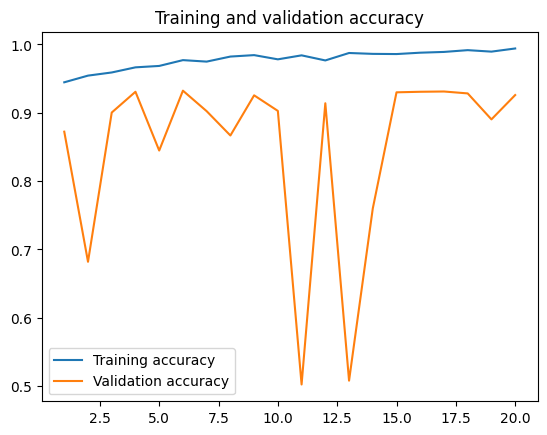

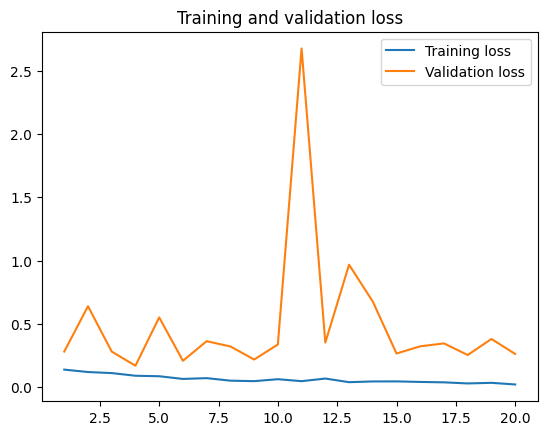

In [105]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [111]:
# Import required libraries
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get true labels from the test data
y_true = test_data.classes

# Get model predictions (probabilities) and convert to class labels
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute and print the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute and print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

63/63 [==============================] - 4s 70ms/step
Confusion Matrix:
[[924  76]
 [ 57 943]]
Classification Report:
              precision    recall  f1-score   support

         Cat       0.94      0.92      0.93      1000
         Dog       0.93      0.94      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

